In [1]:
import pandas as pd
import tensorflow as tf , re
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler
import itertools , dill , umap , seaborn as sns
import matplotlib.pyplot as plt , calendar
from sklearn import datasets , sys
from sklearn.preprocessing import MinMaxScaler
sys.path.append('/home/advice/Python/SR/Custom/')
from RAdam import RAdamOptimizer
from jupyter_tensorboard import *
from utility import *
from Activations import *
from Losses import *
from wasserstein import Wasserstein
from IPython.display import clear_output
import os , collections , warnings
from collections import Counter
import missingno as msno , math
warnings.filterwarnings("ignore")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import keras.backend as k
static = os.path.abspath("./Result")
ModelName = "IITP_GAN_Target_0"
ModelResult = "Models"
ResultPath = os.path.join(static , ModelName)    
ModelResultPath = os.path.join(ResultPath , ModelResult)
if tf.io.gfile.exists(ResultPath) :
    tf.io.gfile.rmtree(ResultPath)
    tf.io.gfile.makedirs(ResultPath)
    tf.io.gfile.makedirs(ModelResultPath)
else :
    tf.io.gfile.makedirs(ResultPath)

/root/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)



    사용하면 좋은 패키지
    st / train_validation_test_split / cat2dict / code2cat / colorlist / onehotencoding / roccurve  / ProbDensity
    pycm import *  
    ConfusionMatrix(actual_vector=``test_y``, predict_vector= ``pred`` ) 
    사용하면 통계량값 다 얻을 수 있음
    
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4042599213542761173
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13141666151216949438
physical_device_desc: "device: XLA_CPU device"
]


Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
path = "/var/disk/total_2020_change_v2.ftr"
data = pd.read_feather(path)

In [4]:
with open('./total_2020_IITP_v2.pkl', 'rb') as rb :
    information = dill.load(rb)

In [5]:
vartypes = deepcopy(information["vartype"])
deletecol = ["farm_no_fake", "occur", "dt"]
for i in deletecol :
    del vartypes[i]
totalcols = data.columns.tolist()
controlcol = ["LATITUDE","LONGITUDE","month_day"]
#[totalcols.remove(i) for i in deletecol + controlcol]

In [6]:
for i in deletecol + controlcol : 
    try :
        totalcols.remove(i)
    except :
        continue

In [7]:
numcol , faccol = [] , []
for key , value in vartypes.items() :
    if key in totalcols :
        if value == "numeric" : numcol.append(key)
        else : faccol.append(key)

In [8]:
fac_uni_info = {}
for fac in faccol :
    result = data[fac].unique().tolist()
    result = np.array(result)[~np.isnan(result)].tolist()
    fac_uni_info[fac] = result

In [9]:
data = data[data.occur == 0]
data.drop(["occur"], axis=1, inplace = True)
data = data.reset_index(drop=True)
controlcol = ["LATITUDE","LONGITUDE","month_day"]
control_variables = data[controlcol]
data.drop(controlcol,axis = 1 , inplace=True)

In [10]:
farm = data.pop("farm_no_fake")

In [11]:
for col in faccol :
    data[col] = pd.Series(pd.Categorical(data[col] , categories=fac_uni_info[col],ordered=False))

In [12]:
m = MinMaxScaler(feature_range=(-1,1))
m.fit(data[numcol])
data[numcol] = m.fit_transform(data[numcol])

In [13]:
from scipy.stats import wasserstein_distance as wdist
from IITPutils import *

In [14]:
totalcol = numcol + faccol
data = data[totalcol]

In [15]:
missing_data = (data.isna().values == 1) * 1
miss_sum = data.isna().sum() 
raw_dim = missing_data.shape[1]

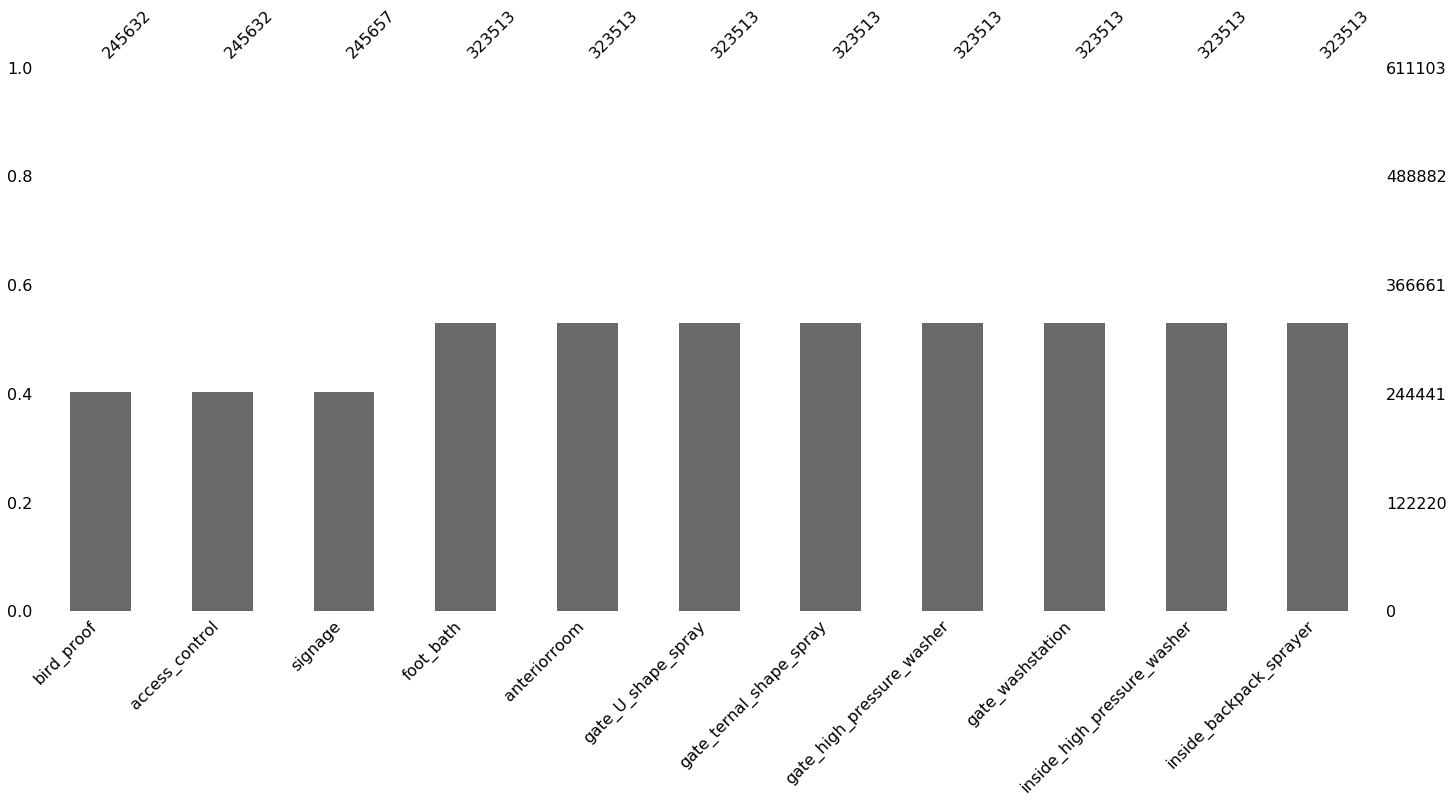

In [16]:
miss_var = miss_sum[miss_sum > 0 ].index.tolist()
msno.bar(data[miss_var])
plt.show()

In [17]:
OneHotdata = pd.get_dummies(data, columns= faccol , dummy_na = False)

In [18]:
f"ONE HOT before : {data.shape} -> after : {OneHotdata.shape}"

'ONE HOT before : (611103, 41) -> after : (611103, 91)'

In [19]:
one_hot_var = OneHotdata.columns.tolist()

In [20]:
onehot_key_store , store = OneHotIndex(totalcol , numcol , one_hot_var)
data.head()

,chicken,turkey,duck,goose,quail,ornamental_bird,pheasant,ostrich,wild_bird,wild_duck,...,access_control,signage,foot_bath,anteriorroom,gate_U_shape_spray,gate_ternal_shape_spray,gate_high_pressure_washer,gate_washstation,inside_high_pressure_washer,inside_backpack_sprayer
0,-0.919668,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,10.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1,-1.000000,-1.0,-0.988235,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.979224,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,-0.997922,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.977839,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [21]:
## if missing : 1 else 0
MissIndicator = CreateMissIndicator(OneHotdata , store , numcol)

In [22]:
OneHotdata.head()

,chicken,turkey,duck,goose,quail,ornamental_bird,pheasant,ostrich,wild_bird,wild_duck,...,gate_ternal_shape_spray_1.0,gate_ternal_shape_spray_0.0,gate_high_pressure_washer_1.0,gate_high_pressure_washer_0.0,gate_washstation_1.0,gate_washstation_0.0,inside_high_pressure_washer_1.0,inside_high_pressure_washer_0.0,inside_backpack_sprayer_1.0,inside_backpack_sprayer_0.0
0,-0.919668,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1,0,1,0,1,0,1,0,1,0
1,-1.000000,-1.0,-0.988235,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0,0,0,0,0,0,0,0,0,0
2,-0.979224,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0,1,0,1,0,1,1,0,1,0
3,-0.997922,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0,0,0,0,0,0,0,0,0,0
4,-0.977839,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0,1,1,0,0,1,1,0,1,0


In [23]:
pd.DataFrame(MissIndicator)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611098,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
611099,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
611100,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
611101,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [24]:
only_one_hot = list(set(one_hot_var).difference(set(numcol)))

In [25]:
OneHotdata[np.sort(only_one_hot)].head()

,access_control_0.0,access_control_1.0,anteriorroom_0.0,anteriorroom_1.0,anteriorroom_10.0,anteriorroom_12.0,anteriorroom_15.0,anteriorroom_16.0,anteriorroom_2.0,anteriorroom_21.0,...,gate_washstation_0.0,gate_washstation_1.0,grow_other_species_except_for_poultry_0.0,grow_other_species_except_for_poultry_1.0,inside_backpack_sprayer_0.0,inside_backpack_sprayer_1.0,inside_high_pressure_washer_0.0,inside_high_pressure_washer_1.0,signage_0.0,signage_1.0
0,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,1,1,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,1,0,1


In [26]:
pd.DataFrame(MissIndicator, columns= one_hot_var)[np.sort(only_one_hot)].head()

,access_control_0.0,access_control_1.0,anteriorroom_0.0,anteriorroom_1.0,anteriorroom_10.0,anteriorroom_12.0,anteriorroom_15.0,anteriorroom_16.0,anteriorroom_2.0,anteriorroom_21.0,...,gate_washstation_0.0,gate_washstation_1.0,grow_other_species_except_for_poultry_0.0,grow_other_species_except_for_poultry_1.0,inside_backpack_sprayer_0.0,inside_backpack_sprayer_1.0,inside_high_pressure_washer_0.0,inside_high_pressure_washer_1.0,signage_0.0,signage_1.0
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# 결측치 처리
* numerical variable은 그대로 사용
* categorical variable 결측치를 고민중
    * 기존과 동일하게 sigmoid로 하고 나서, 0이면 0으로 채우고 1이면 1로 채우는 형태로하기
    * 그리고 한개의 값으로 추출할 때는 na로 만들기

In [27]:
overall_where = []
for key , values in onehot_key_store.items() :
    first , to = values
    diff = to-first
    if diff == 1 :
        final = to
        continue
    else :
        if len(overall_where) == 0 :
            overall_where.append([0,final])
            overall_where.append(values)
        else :
            overall_where.append(values)

In [28]:
from IITPGAN import *

In [29]:
n_dim = len(OneHotdata.columns.tolist())
raw_dim = raw_dim
g_dim = len(OneHotdata.columns.tolist()) * 2

In [30]:
data.shape

(611103, 41)

In [31]:
IITPGAN_Model = IITP(n_dim=n_dim, raw_dim= raw_dim, g_dim=g_dim,
                     n_control=control_variables.shape[1], overall_where=overall_where,
                     onehot_key_store = onehot_key_store
                    )

In [32]:
IITPGAN_Model.fit(dishsize = [250, 150, 75 ,50, 20],
                  misdishsize = [200, 100, 50, 20] ,
                  glr = 5e-4, dlr = 9e-4,
                 )

W0322 10:47:10.505463 139710813021952 module_wrapper.py:139] From /home/advice/Python/SR/Custom/IITPGAN.py:38: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0322 10:47:10.506629 139710813021952 module_wrapper.py:139] From /home/advice/Python/SR/Custom/IITPGAN.py:39: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0322 10:47:10.513630 139710813021952 module_wrapper.py:139] From /home/advice/Python/SR/Custom/IITPLayer.py:49: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0322 10:47:10.518007 139710813021952 module_wrapper.py:139] From /home/advice/Python/SR/Custom/IITPutils.py:183: The name tf.keras.initializers.he_uniform is deprecated. Please use tf.compat.v1.keras.initializers.he_uniform instead.

W0322 10:47:10.519038 139710813021952 module_wrapper.py:139] From /home/advice/Python/SR/Custom/IITPutils.py:184: The name tf.keras.initializers.he_norma

G_FC       output : [None, 392]
deconv1    output : [None, 9, 9, 4]
deconv2    output : [None, 11, 11, 4]
deconv3    output : [None, 13, 13, 4]


W0322 10:47:10.825262 139710813021952 deprecation.py:323] From /root/anaconda3/lib/python3.6/site-packages/tensorflow_core/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


G_FC1      output : [None, 141]
G_FC2      output : [None, 121]
G_Final    output : [None, 91]
grow_other_species_except_for_poultry / diff : 2
bird_proof / diff : 2
access_control / diff : 2
signage / diff : 2
foot_bath / diff : 27
anteriorroom / diff : 15
gate_U_shape_spray / diff : 2
gate_ternal_shape_spray / diff : 2
gate_high_pressure_washer / diff : 2
gate_washstation / diff : 2
inside_high_pressure_washer / diff : 2
inside_backpack_sprayer / diff : 2
G_Miss1    output : [None, 82]


W0322 10:47:11.413077 139710813021952 deprecation.py:323] From /home/advice/Python/SR/Custom/IITPGAN.py:54: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


G_Miss2    output : [None, 49]
G_Miss_Final output : [None, 41]
D_FC0      output : [None, 250]
D_FC1      output : [None, 150]
D_FC2      output : [None, 75]
D_FC3      output : [None, 50]
D_FC4      output : [None, 20]
D_Final    output : [None, 1]
D_FC0      output : [None, 250]
D_FC1      output : [None, 150]
D_FC2      output : [None, 75]
D_FC3      output : [None, 50]
D_FC4      output : [None, 20]
D_Final    output : [None, 1]
D_Miss_FC0 output : [None, 200]
D_Miss_FC1 output : [None, 100]
D_Miss_FC2 output : [None, 50]


W0322 10:47:12.481897 139710813021952 module_wrapper.py:139] From /home/advice/Python/SR/Custom/IITPGAN.py:73: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W0322 10:47:12.483237 139710813021952 module_wrapper.py:139] From /home/advice/Python/SR/Custom/IITPGAN.py:73: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.



D_Miss_FC3 output : [None, 20]
D_Miss_Indicator output : [None, 1]
D_Miss_FC0 output : [None, 200]
D_Miss_FC1 output : [None, 100]
D_Miss_FC2 output : [None, 50]
D_Miss_FC3 output : [None, 20]
D_Miss_Indicator output : [None, 1]


W0322 10:47:12.532125 139710813021952 module_wrapper.py:139] From /home/advice/Python/SR/Custom/IITPGAN.py:75: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



D_FC0      output : [None, 250]
D_FC1      output : [None, 150]
D_FC2      output : [None, 75]
D_FC3      output : [None, 50]
D_FC4      output : [None, 20]
D_Final    output : [None, 1]


W0322 10:47:13.001246 139710813021952 module_wrapper.py:139] From /home/advice/Python/SR/Custom/IITPGAN.py:101: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W0322 10:47:13.007864 139710813021952 module_wrapper.py:139] From /home/advice/Python/SR/Custom/IITPGAN.py:106: The name tf.trainable_variables is deprecated. Please use tf.compat.v1.trainable_variables instead.

W0322 10:47:13.012169 139710813021952 module_wrapper.py:139] From /home/advice/Python/SR/Custom/IITPGAN.py:108: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0322 10:47:13.013570 139710813021952 module_wrapper.py:139] From /home/advice/Python/SR/Custom/IITPGAN.py:114: The name tf.train.exponential_decay is deprecated. Please use tf.compat.v1.train.exponential_decay instead.

W0322 10:47:16.384240 139710813021952 module_wrapper.py:139] From /home/advice/Python/SR/Custom/IITPGAN.py:122: The name tf.train.RMSPropOptimizer is deprecated. Please u

fitting!!


I0322 11:08:23.075268 139710813021952 IITPGAN.py:252] ========== Epoch : 300 ==========
I0322 11:08:23.077049 139710813021952 IITPGAN.py:253] [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.]]
I0322 11:08:23.080802 139710813021952 IITPGAN.py:254] [[-0.94595605 -0.9882576          nan -0.9883213  -0.97880065 -0.966277
  -0.9593047  -0.9805538  -0.98503965 -0.9710486  -0.98970664 -0.95977753
  -0.9372407  -0.9892024  -0.9430495  -0.8589189          nan -0.97063935
  -0.9937542  -0.96322083         nan -0.9672447   0.63826305 -0.21908538
  -0.35061064 -0.49463013 -0.8741695  -0.9878957  -0.9670545   0.
          nan  0.                 nan         nan         nan         nan
          nan         nan  1.                 nan         nan]]


    chicken    turkey  duck     goose     quail  ornamental_bird  pheasant  \
0 -0.945956 -0.988258   NaN -0.988321 -0.978801        -0.966277 -0.959305   

    ostrich  wild_bird  wild_duck  ...  access_control  signage  foot_bath  \
0 -0.980554   -0.98504  -0.971049  ...             0.0      NaN        NaN   

   anteriorroom  gate_U_shape_spray  gate_ternal_shape_spray  \
0           NaN                 NaN                      NaN   

   gate_high_pressure_washer  gate_washstation  inside_high_pressure_washer  \
0                        NaN               1.0                          NaN   

   inside_backpack_sprayer  
0                      NaN  

[1 rows x 41 columns]


I0322 11:09:01.993898 139710813021952 IITPGAN.py:284] [300] distnace : 20.140544000000002 -> 12.540256000000001


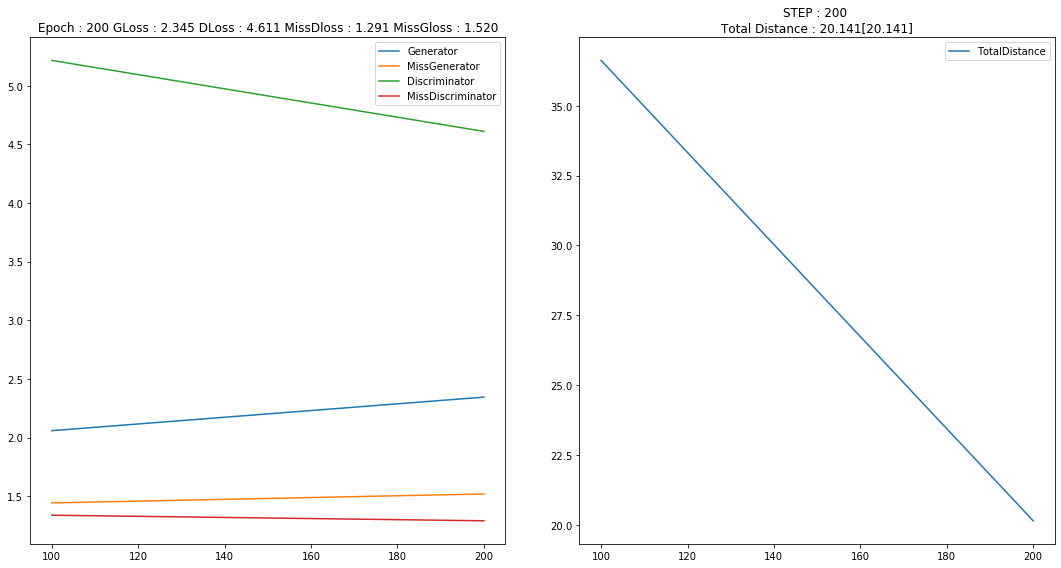

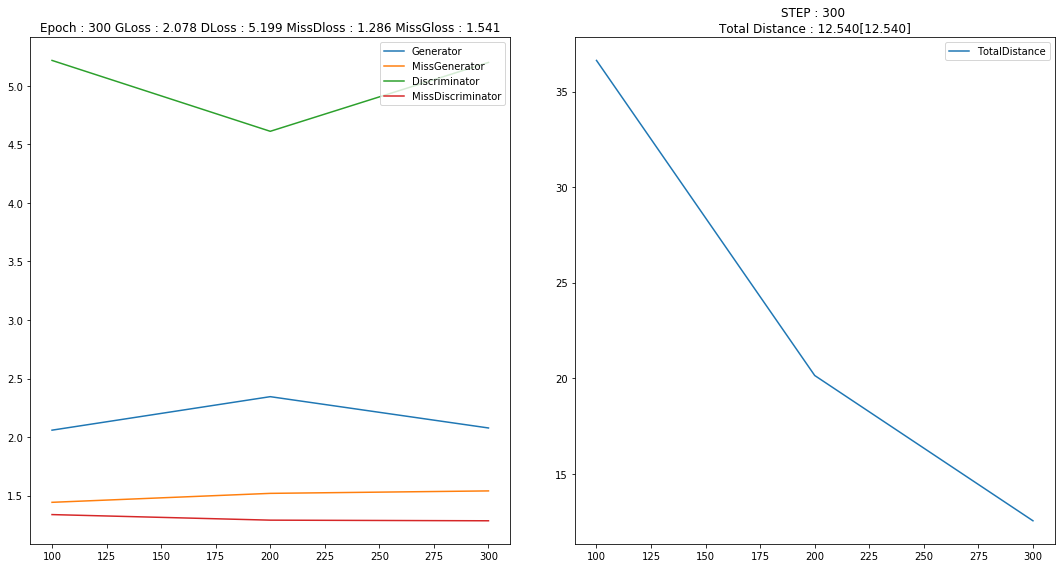

In [ ]:
IITPGAN_Model.learn(steps=100000 , BATCH_SIZE=10000, gd_steps = [1,3] ,totalcol =totalcol,
                    data = data  ,OneHotdata=OneHotdata, missing_data = missing_data ,
                    control_variables = control_variables  ,
                    ModelResultPath = ModelResultPath, ResultPath = ResultPath, 
                    LogPath = "iitp_target_0.txt", per=100)